In [2]:
import networkx as nx
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
%matplotlib inline

## Util Functions

In [3]:
def get_sheet_name_list(path, x):
    df = pd.read_excel(path, sheet_name=[x])[x]["-"]
    return df.to_numpy()

In [4]:
def get_dataframe(path, colnames):
    sheet_list = get_sheet_name_list("./data/list.xlsx", "Sheet1").tolist()
    df = pd.read_excel(path[0], sheet_name=sheet_list)

    sheet_list = get_sheet_name_list("./data/list.xlsx", "Sheet2").tolist()
    df1 = pd.read_excel(path[1], sheet_name=sheet_list)

    df.update(df1)

    dat = {}
    for el in df:
        dat[el] = df[el][colnames]

    return dat, sheet_list

In [5]:
def get_df_for_year(df, year):
    for el in df:
        t = df[el]
        df[el] = t.loc[t.Year == year]

    return df

In [6]:
def get_commodities(df):
    commodities = np.array([], dtype=str)

    for el in df:
        commodities = np.union1d(commodities, df[el]["Commodity"].to_numpy(dtype=str))

    return commodities

In [7]:
def get_commodity_freq(df, commodities):
    commodity_cnt = {}
    for c in commodities:
        commodity_cnt[c] = 0

    for el in df:
        for c in df[el]["Commodity"].to_numpy():
            commodity_cnt[c] += 1

    return commodity_cnt

In [8]:
def get_edge_data(df, commodities):
    data = {}
    for c in commodities:
        data[c] = {}

    for country in df:
        for r in df[country].iterrows():
            row = r[1]
            c, t = row["Commodity"], row["Trade Value (US$)"]
            data[c][country] = t

    return data

In [9]:
def commodity_graph(commodity, data):
    G = nx.DiGraph()
    G.add_nodes_from(data.keys())

    for c1, t1 in data.items():
        for c2, t2 in data.items():
            if c1 != c2 and t1 > t2:
                G.add_edge(c1,c2,weight=t1/t2,commodity=commodity)

    return G

def check_graph_weights_labels(G, commodity):
    for d in G.edges(data=True):
        if (d[2]["weight"] < 1 or d[2]["commodity"] != commodity):
            print(d)
            return False
    return True

## Config

In [11]:
year = 2010
i = 0

## Begin

In [12]:
print("Fetching data...")
df, sheet_list = get_dataframe(["./data/A-M Master File(00-28).xlsx", "./data/N-Z Master File(00-28).xlsx"], ["Year", "Commodity", "Trade Value (US$)"])
print("There you go!")

Fetching data...
There you go!


In [13]:
df_2010 = get_df_for_year(df, 2010)
commodities = get_commodities(df_2010)

In [14]:
commodities

array(['ANIMAL FEED STUFF', 'BEVERAGES', 'CEREALS,CEREAL PREPRTNS.',
       'COFFEE,TEA,COCOA,SPICES', 'CORK AND WOOD',
       'CRUDE FERTILIZER,MINERAL', 'CRUDE RUBBER',
       'DAIRY PRODUCTS,BIRD EGGS', 'FISH,CRUSTACEANS,MOLLUSC',
       'HIDES,SKINS,FURSKINS,RAW', 'LIVE ANIMALS',
       'MEAT, MEAT PREPARATIONS', 'METALLIFEROUS ORE,SCRAP',
       'MISC.EDIBLE PRODUCTS ETC', 'OIL SEED,OLEAGINUS FRUIT',
       'PULP AND WASTE PAPER', 'SUGAR,SUGR.PREPTNS,HONEY',
       'TEXTILE FIBRES', 'TOBACCO,TOBACCO MANUFACT',
       'VEGETABLES AND FRUIT'], dtype='<U24')

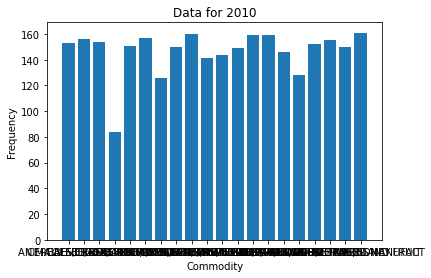

In [15]:
commodity_freq = get_commodity_freq(df_2010, commodities)

plt.bar(range(len(commodity_freq)), commodity_freq.values())
plt.xticks(range(len(commodity_freq)), commodity_freq.keys())
plt.xlabel("Commodity")
plt.ylabel("Frequency")
plt.title("Data for 2010")
plt.show()

In [16]:
data_2010 = get_edge_data(df_2010, commodities)

c = commodities[i]
gg = commodity_graph(c, data_2010[c])

assert check_graph_weights_labels(gg, c), "check graph"

In [50]:
data = data_2010[c]

In [51]:
edges = []
weights = []

for c1, t1 in data.items():
    for c2, t2 in data.items():
        if c1 != c2 and t1 > t2:
            edges.append((c1,c2))
            weights.append(t1/t2)

In [52]:
import igraph as ig

In [53]:
g = ig.Graph()

g.add_vertices(list(data.keys()))
g.add_edges(edges)
g.es["weight"] = weights

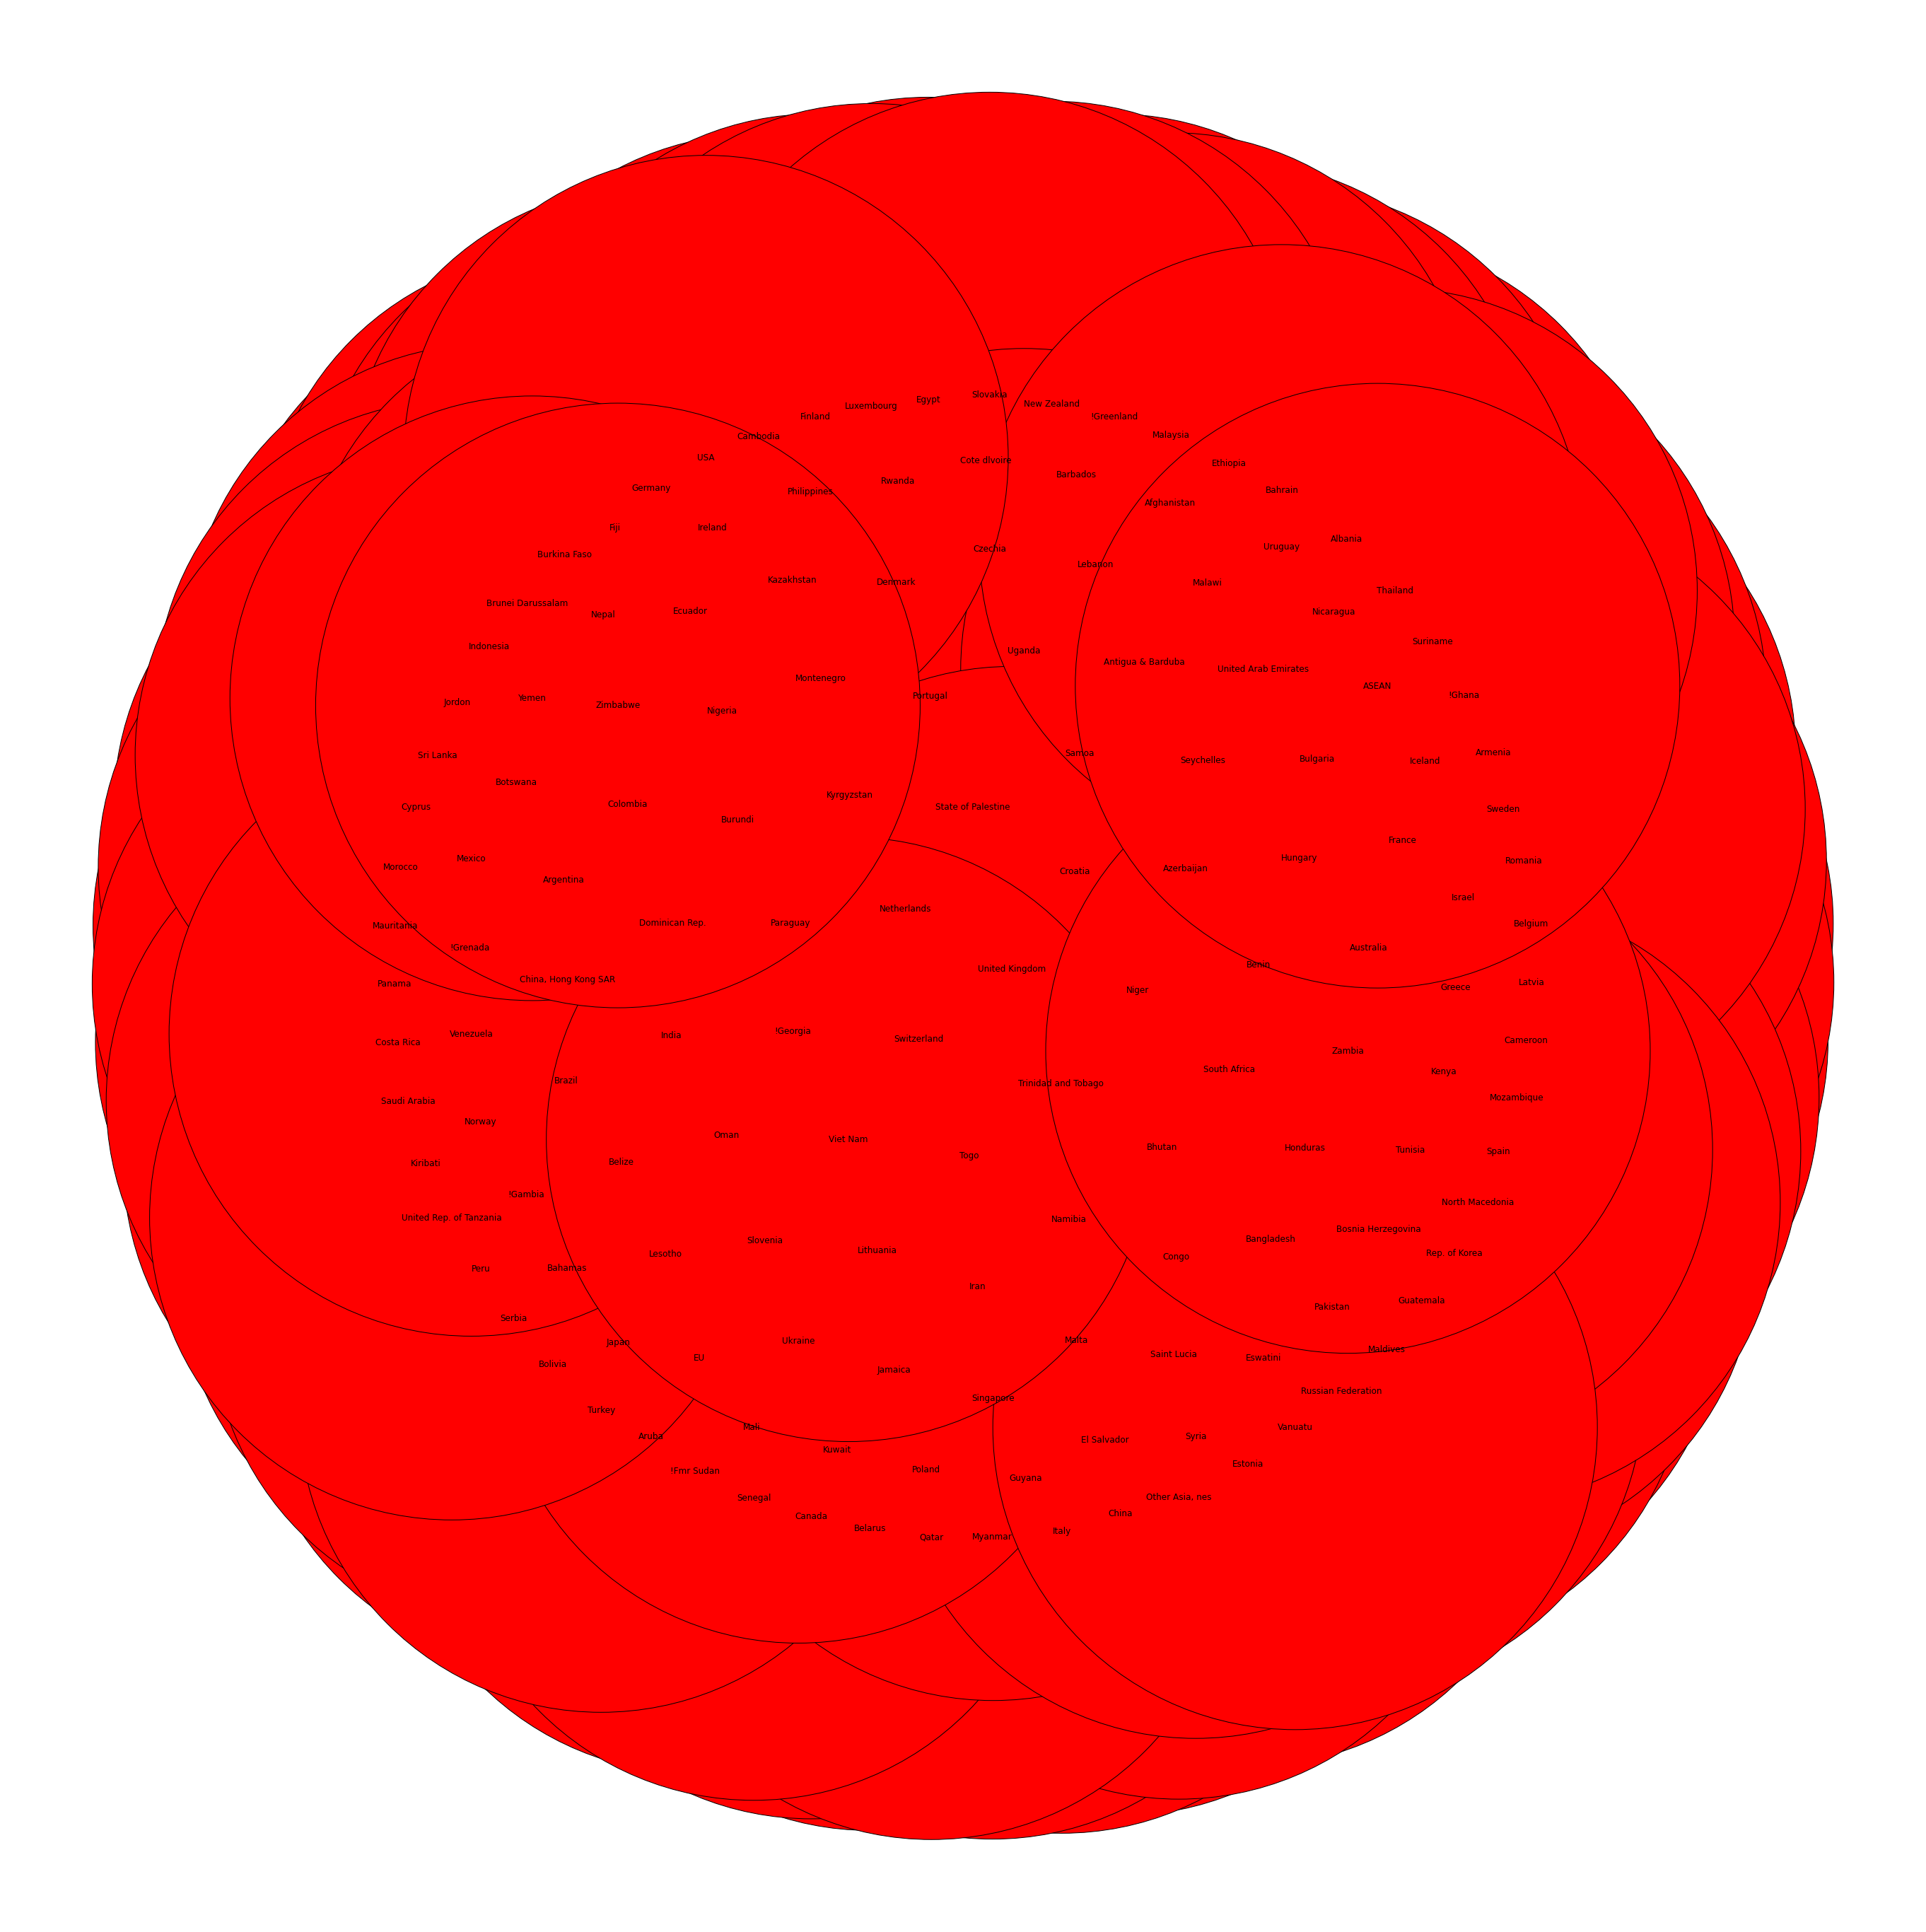

In [59]:
fig, ax  = plt.subplots(figsize=(50, 50))
ig.plot(
    g, layout="kk", vertex_label=list(data.keys()), 
    vertex_size=10, edge_width=0.5, edge_arrow_size=0.5, 
    edge_arrow_width=0.5, edge_color="black", vertex_color="red", 
    bbox=(0, 0, 1000, 1000), target=ax
)
plt.show()